In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
sys.path.insert(1, r'C:\Users\smartin5\Repos\myNeurochat')
#sys.path.insert(1, r'C:\Users\maolivei\neuro_sean\NeuroChaT')
%load_ext autoreload
%autoreload 2

In [2]:
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
from neurochat.nc_data import NData
from neurochat.nc_datacontainer import NDataContainer
import neurochat.nc_plot as nc_plot
import neurochat.nc_containeranalysis as nca
from neurochat.nc_clust import NClust
from neurochat.nc_utils import butter_filter
from neurochat.nc_utils import find_peaks

import numpy as np

In [3]:
# Setup the main data path
home = os.path.expanduser("~")
data_dir = os.path.join(
    home, "Recordings", "LCA1")
prepend_data_dir = lambda name : os.path.join(data_dir, name)

In [4]:
# Load the data
"""
spike_filenames = [
    "LCA1-linearpresleep30min050319.2",
    "050319D_LCA1_linear_10min.2",
    "LCA1-linearpresleep_40min050319_B.2"]
"""

spike_filenames = [
#    "LCA1-linearpresleep30min060319.2",
    "060319D_LCA1_linear_15min.2",
    "060319E_LCA1_linear_sleep_32min.2"]

spike_absolute_filenames = [prepend_data_dir(name) for name in spike_filenames]

spike_names = [
#    "pre-sleep",
    "run",
    "post-sleep"]

position_absolute_filenames = [f[:-2] + ".txt" for f in spike_absolute_filenames]

lfp_end = ".egf"

lfp_absolute_filenames = [f.split(".")[0] + lfp_end for f in spike_absolute_filenames]
print(lfp_absolute_filenames)

collection = NDataContainer(share_positions=False, load_on_fly=True)
collection.add_files(
    NDataContainer.EFileType.Spike, (spike_absolute_filenames, spike_names, None))
collection.add_files(
    NDataContainer.EFileType.LFP, lfp_absolute_filenames
)
collection.add_files(
    NDataContainer.EFileType.Position, position_absolute_filenames)

collection.setup()

['C:\\Users\\smartin5\\Recordings\\LCA1\\060319D_LCA1_linear_15min.egf', 'C:\\Users\\smartin5\\Recordings\\LCA1\\060319E_LCA1_linear_sleep_32min.egf']


In [5]:
collection.list_all_units()


units are [1, 2, 3, 4, 5, 6]
units are [1, 2, 3, 4, 5, 6, 7, 8]


In [96]:
# Setup the appropriate units
# collection.set_units(["all", "all"])
run_units = [3, 2, 4] # top, middle, bottom is 2, 3, 4
sleep_units = [2, 3, 4, 6, 7, 8] # Units from powerpoint file
collection.set_units([run_units, sleep_units])

In [28]:
eval_clust = nca.evaluate_clusters(collection, 0, 1, set_units=True)

2 4: Bhattacharyya 0.06509419835351257 Hellinger 0.9669052702547895
2 8: Bhattacharyya 5.132838640500395e-06 Hellinger 0.9999974335773865
2 7: Bhattacharyya 0.003785759704020577 Hellinger 0.998105325251789
3 4: Bhattacharyya 2.5438437078066536e-06 Hellinger 0.9999987280773373
3 8: Bhattacharyya 0.01912682809453879 Hellinger 0.990390413880032
3 7: Bhattacharyya 0.027131643619808552 Hellinger 0.9863408925823726
4 4: Bhattacharyya 0.0018786580680948245 Hellinger 0.9990602293815449
4 8: Bhattacharyya 0.0006201886625760006 Hellinger 0.99968985757455
4 7: Bhattacharyya 0.09437441910505698 Hellinger 0.9516436207398982
Best assignment is {2: (4, 0.9669052702547895), 3: (8, 0.990390413880032), 4: (7, 0.9516436207398982)}


In [62]:
peaks = nca.replay(collection, 0, 1)
print(peaks)

[ 924.42895833  924.430625    924.45395833 ... 1882.47604167 1884.96645833
 1884.96895833]
[ 924.42895833  924.430625    924.45395833 ... 1882.47604167 1884.96645833
 1884.96895833]


In [68]:
print(peaks[:10])
print(len(peaks))

[924.42895833 924.430625   924.45395833 924.45625    924.45875
 924.46125    924.46354167 924.46583333 924.47333333 924.47583333]
3719


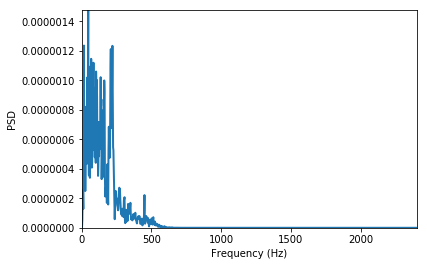

In [29]:
# Spectrum plot
graph_data = collection.get_data(1).lfp.spectrum(
    window = 0.4, noverlap = 0.04, nfft = 2048, ptype = 'psd', 
    prefilt = True, filtset = [10, 100, 'highpass'], 
    fmax = 2400, db = False, tr = False, slice=slice(0, 9600, 1))
fig = nc_plot.lfp_spectrum(graph_data)

In [30]:
def window_rms(a, window_size, mode="same"):
    """
    Calculates the rms envelope, similar to matlab - mode determines how many points are output
    mode valid will have no border effects, while same will produce a value for each input
    """
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, mode))

In [31]:
def distinct_window_rms(x, N):
    """
    Calculates the rms of x in windows of N data points
    """
    x = np.array(x)
    x = np.square(x) / float(N)
    rms_array = []
    rms = 0
    
    # For now, just throw away the last window if it does not fit
    for idx, point in enumerate(x):
        rms += point
        if idx % N == N-1:
            rms_array.append(np.sqrt(rms))
            rms = 0
    return rms_array

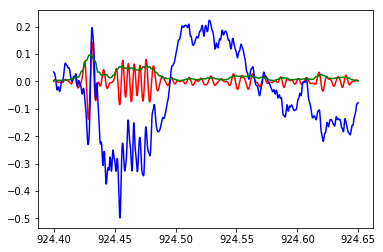

In [67]:
# Displaying the filtered data
fs = collection.get_data(1).lfp.get_sampling_rate()
sample_start = int((924.4 * 4800))
sample_end = sample_start + 1200
lfp_samples = collection.get_data(1).get_samples()[sample_start:sample_end]
time = collection.get_data(1).lfp.get_timestamp()
filtered_lfp = butter_filter(lfp_samples, fs, 10, 100, 240, 'bandpass') # SWR
rms_data = window_rms(filtered_lfp, 33, "same")
ax, fig = nc_plot._make_ax_if_none(None)
ax.plot(time[sample_start:sample_end], filtered_lfp, color='r')
ax.plot(time[sample_start:sample_end], lfp_samples, color='b')
ax.plot(time[sample_start:sample_end], rms_data, color='g')

In [ ]:
# This needs some extra work to better deal with overlapping intervals, use distinct for now to combat this
# Could use the derivative to find the peaks - see nc_utils.py commented out - combine this with percentile
run = collection.get_data(1)
run.set_unit_no(1)
sleep_lfps = np.array(run.non_moving_periods(min_range=150, moving_thresh=2.5)) * 4800
sample_start = sleep_lfps[1]
lfp_samples = run.get_samples()[int(sample_start[0]):int(sample_start[1])]
filtered_lfp = butter_filter(lfp_samples, fs, 10, 120, 240, 'bandpass')
rms_window_size = 33 # 0.007 / (1/4800)
rms_data = distinct_window_rms(filtered_lfp, rms_window_size) # 7ms windows
p99 = np.percentile(rms_data, 99)
peaks = (sample_start[0] + np.argwhere(rms_data > p99).flatten() * rms_window_size) / 4800

from neurochat.nc_utils import find_peaks
_, peaks2 = find_peaks(rms_data, thresh=p99)
peaks2 = (sample_start[0] + peaks2 * rms_window_size) / 4800

window = 0.20 # 400ms windows
ranges = [(i - window, i + window) for i in peaks]

In [81]:
# Calculate out the things from the synaptic paper - should be self contained
sleep = collection.get_data(1)
sleep_lfps = np.array(sleep.non_moving_periods(min_range=150, moving_thresh=2.5)) * 4800
sample_start = sleep_lfps[1]

fs = collection.get_data(1).lfp.get_sampling_rate()
lfp_samples = collection.get_data(1).get_samples()[int(sample_start[0]):int(sample_start[1])]
time = collection.get_data(1).lfp.get_timestamp()[int(sample_start[0]):int(sample_start[1])]
filtered_lfp = butter_filter(lfp_samples, fs, 10, 100, 250, 'bandpass')
rms_window_size = 33 # 7ms
rms_data = distinct_window_rms(filtered_lfp, rms_window_size)
p99 = np.percentile(rms_data, 99)
peaks = (sample_start[0] + np.argwhere(rms_data > p99).flatten() * rms_window_size) / 4800
# This detects the up and down peaks together - probably not desirable
_, peaks2 = find_peaks(rms_data, thresh=p99)
peaks2 = (sample_start[0] + peaks2 * rms_window_size) / 4800
unit_hist = nca.count_units_in_bins(collection.subsample(1), 1, sample_start / 4800)

In [91]:
print(peaks2[0])

924.423125


In [82]:
collection.sort_units_spatially([True, False], mode="vertical")
raw_spikes = nca.spike_times(collection.subsample(1), ranges=[sample_start / 4800])

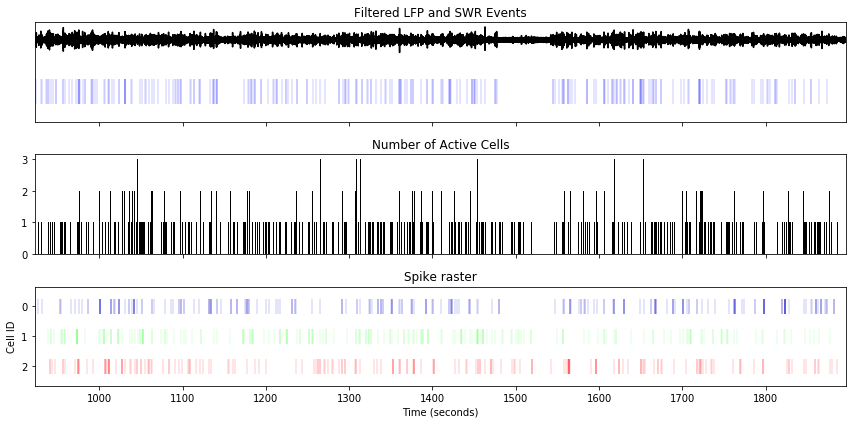

In [89]:
fig = nc_plot.replay_summary(
    time, filtered_lfp, unit_hist, peaks2, 3, 4800, raw_spikes)

Best assignment is {2: (4, 0.9669052702547893), 3: (8, 0.9903904138800321), 4: (7, 0.9516436207398977)}


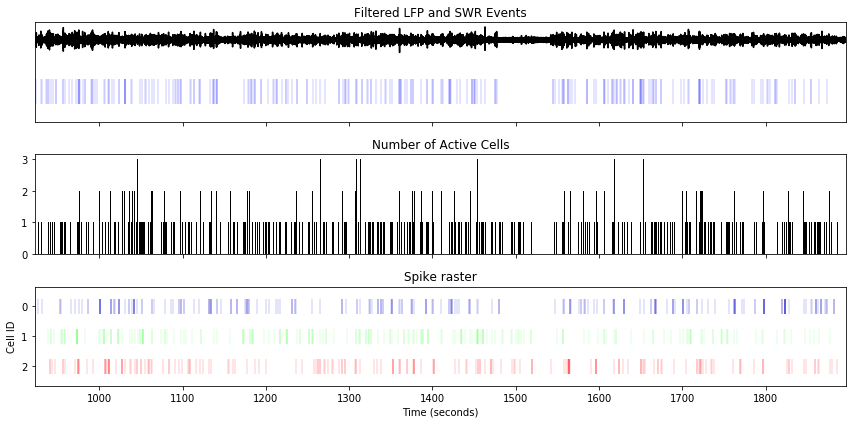

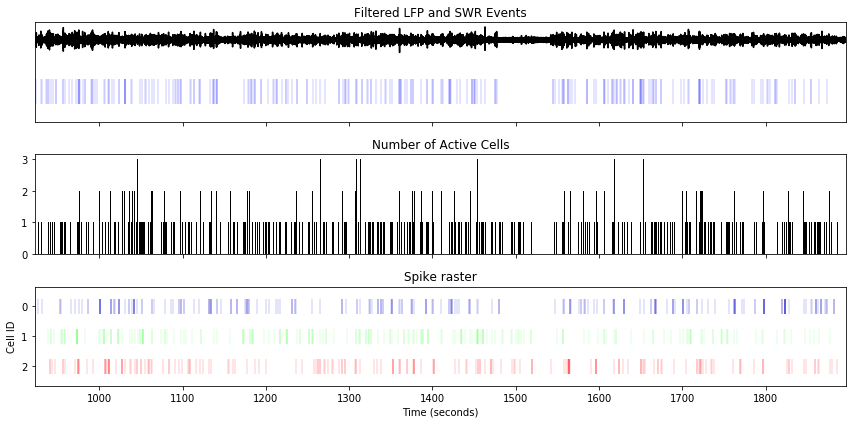

In [98]:
results = nca.replay(collection, 0, 1)
nca.plot_replay(results)

In [95]:
swr_amt = len(results["swr times"])
lfp_amt = len(results["lfp samples"])
print(100 * swr_amt / lfp_amt)

0.07952290533374388


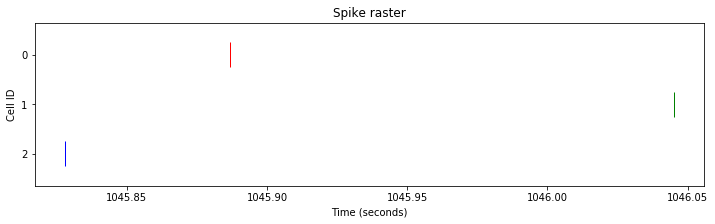

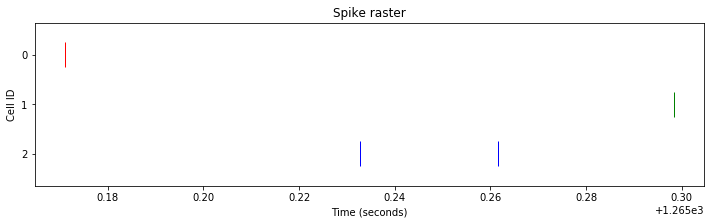

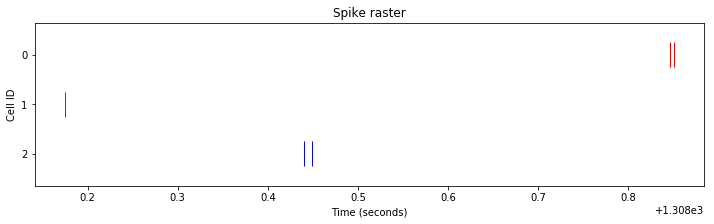

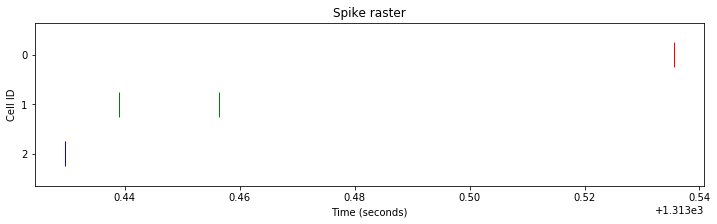

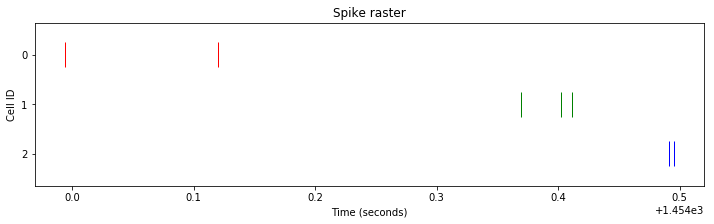

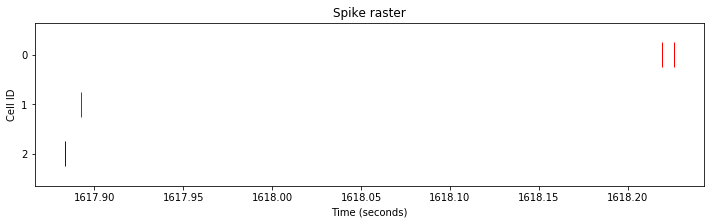

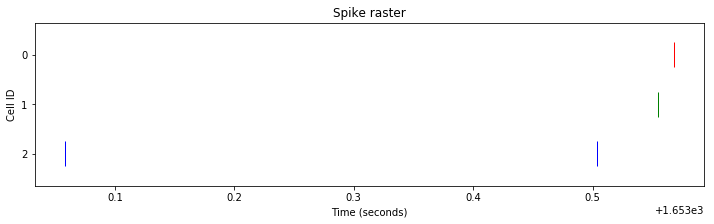

In [99]:
# Look at an areas of interest
sleep_samp = collection.subsample(1)
mua_indices = np.argwhere(unit_hist[0] == 3)
interest_ranges = []
for mua in [unit_hist[1][j] for j in mua_indices.flatten()]:
    # Is the centre lying in a SWR
    if any(
        mua - 0.5 <= peak - 0.4 <= mua + 0.5 or
        mua - 0.5 <= peak + 0.4 <= mua + 0.5
        for peak in peaks2
    ):
        interest_ranges.append((mua - 0.5, mua + 0.5)) # 1sec bins

# Plot the interest ranges
for mua in [unit_hist[1][j] for j in mua_indices.flatten()]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,3))
    nc_plot.spike_raster(nca.spike_times(sleep_samp, ranges=[(mua - 0.5, mua + 0.5)]), linewidths=1, ax=ax, colors=colors)

In [45]:
# Plot the interest ranges
for interest_range in interest_ranges:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,3))
    nc_plot.spike_raster(nca.spike_times(sleep_samp, ranges=[interest_range]), linewidths=1, ax=ax, colors=colors)

plt.tight_layout()
plt.savefig("raster.png", dpi=600)

<Figure size 432x288 with 0 Axes>

In [ ]:
print(interest_ranges)
start = int(interest_ranges[1][0] *4800 - sample_start[0])
end = int((interest_ranges[1][1] + 3) * 4800 - sample_start[0])
plt.plot(time[start:end], filtered_lfp[start:end], color='k') # filtered LFP
plt.show()

In [ ]:
pre_sleep = collection.get_data(0)
lfp = pre_sleep.lfp.get_samples()
ax, fig = nc_plot._make_ax_if_none(None)
time = [i * (1 / pre_sleep.lfp.get_sampling_rate()) for i in range(len(lfp))]
ax.plot(time[:19200], lfp[:19200])

In [ ]:
# Count the number of spikes which occur when the rat is not moving
# not_moving = pre_sleep.get_speed() < 3
# count = 0
# for i in not_moving:
#     count += int(i)
# print(count, len(not_moving)-count)
# #not_moving_spikes = pre_sleep.spike

In [ ]:
for i in range(collection.get_num_data()):
    run = collection.get_data(i)
    run.smooth_speed()
    ax, fig = nc_plot._make_ax_if_none(None)
    ax.plot(run.spatial.get_time(), run.get_speed())
    ax.set_xlim(0, run.get_recording_time())